# spaCy pipeline evaluation

This notebook is used to evaluate the entire spaCy pipeline. It compares the predictions of the pipeline with the ground truth author and affiliation data, along with predictions made using other strategies.

Ground truth authors and affiliations were cataloged by hand using SHROOM, and are downloaded as Cocina from SDR by the `preprints:download` task (see README.md). This needs to be run prior to running this notebook.

Article plain texts are extracted from the PDFs using the `preprints:clean` task (see README.md). This also needs to be run prior to running this notebook.

If predictions have already been saved to the `output/spacy` folder, those will be loaded and used. Otherwise, new predictions will be run and saved there.

In [1]:
# set up project root path for imports
import sys
import os
import pathlib
root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
PROJECT_ROOT = pathlib.Path(root)

# make scripts in scripts/ importable and import util functions
sys.path.insert(1, str(PROJECT_ROOT / 'scripts'))
from notebook_utils import get_preprint_text, get_gold_affiliations, load_predictions

# Load the models
import spacy
ner = spacy.load("en_core_web_trf")
ner.disable_pipes("parser")
textcat = spacy.load(PROJECT_ROOT / 'training' / 'textcat' / 'model-best')


/Users/budak/.pyenv/versions/3.12.2/envs/ezdeposit/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/budak/.pyenv/versions/3.12.2/envs/ezdeposit/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/budak/.pyenv/versions/3.12.2/envs/ezdeposit/lib/python3.12/site-packages/thinc/shims/pytorch.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#

In [2]:
# set up data table with columns for gold and predicted affiliations
import pandas as pd
preprints = pd.read_csv(PROJECT_ROOT / 'assets' / 'preprints.csv')
preprints['gold'] = ''

# add the full text and gold affiliations to the data table
for i, row in preprints.iterrows():
    preprint_id = row['OpenAlex ID']
    preprint_text = get_preprint_text(preprint_id)
    preprint_file = PROJECT_ROOT / "assets" / "preprints" / "pdf" / f"{preprint_id}.pdf"
    preprints.at[i, 'gold'] = get_gold_affiliations(preprint_id)
    preprints.at[i, 'text'] = preprint_text
    

# keep only the columns we need
preprints = preprints[['OpenAlex ID', 'DRUID', 'text', 'gold']]

# limit to only rows where we have gold affiliations
preprints = preprints[preprints['gold'] != '']

In [3]:
from utils import get_affiliation_dict, analyze_pdf_text
from notebook_utils import RESULTS_PATH, load_predictions
from tqdm.notebook import tqdm
import json

# set this and run cell to force re-running predictions
FORCE_RERUN = False

# add a column for predictions
preprints['pred'] = ''

# if we don't have any saved predictions, run prediction for every preprint
spacy_results_path = RESULTS_PATH / "spacy"
predictions = load_predictions(spacy_results_path)
if not predictions or FORCE_RERUN:
    print("No predictions found, running prediction for all preprints")
    for i, row in tqdm(preprints.iterrows(), total=len(preprints), desc="Predicting"):
        preprint_id = row['OpenAlex ID']
        preprint_file = PROJECT_ROOT / "assets" / "preprints" / "txt" / f"{preprint_id}.txt"
        pdf_text = preprint_file.read_text(encoding='utf-8')
        try:
            result = analyze_pdf_text(pdf_text, textcat, ner)
            affiliations = get_affiliation_dict(result)
        except ValueError as e:
            print(f"Error analyzing {preprint_id}: {e}")
            affiliations = {}
        with (spacy_results_path / f"{preprint_id}.json").open(mode="w") as f:
            json.dump(affiliations, f)
    predictions = load_predictions(spacy_results_path)
else:
    print("Using saved predictions")

# set predictions for each preprint in the data table
for i, row in preprints.iterrows():
    preprint_id = row['OpenAlex ID']
    if preprint_id in predictions:
        preprints.at[i, 'pred'] = predictions[preprint_id]

No predictions found, running prediction for all preprints


Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

Error analyzing W3178821884: No affiliations found in document.
Error analyzing W3116436840: No affiliations found in document.
Error analyzing W4226047880: No affiliations found in document.


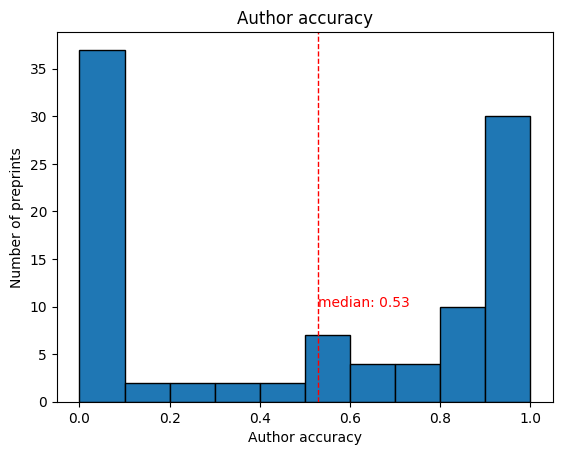

In [4]:
# calculate some accuracy statistics for authors
for i, row in preprints.iterrows():
    gold = row.gold
    pred = row.pred
    correct = 0
    total = 0
    for author in gold:
        total += 1
        if author in pred:
            correct += 1
    preprints.at[i, 'authors_accuracy'] = correct / total if total > 0 else (1 if correct == 0 else 0)

# print a histogram of author accuracy per preprint
%matplotlib inline
import matplotlib.pyplot as plt
author_acc = preprints['authors_accuracy']
author_acc_median = author_acc.median()
plt.hist(author_acc, edgecolor='black')
plt.xlabel('Author accuracy')
plt.ylabel('Number of preprints')
plt.title('Author accuracy')
plt.axvline(author_acc_median, color='r', linestyle='dashed', linewidth=1) 
plt.text(author_acc_median, 10, f'median: {author_acc_median:.2f}', color='r')
plt.show()

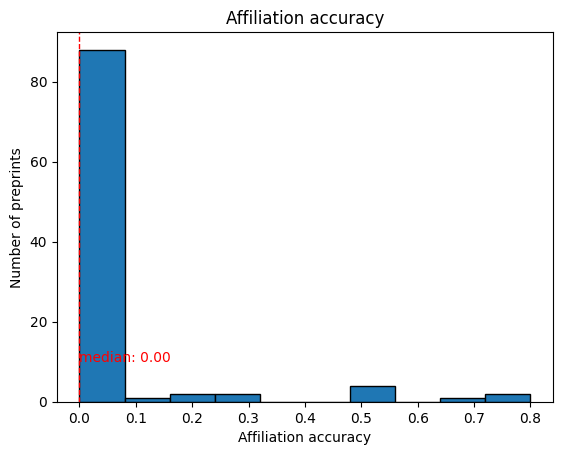

In [5]:
# calculate some accuracy statistics for affiliations
for i, row in preprints.iterrows():
    gold = row.gold
    pred = row.pred
    correct = 0
    total = 0
    for author in gold:
        for affiliation in gold[author]:
            total += 1
            if author in pred and affiliation in pred[author]:
                correct += 1
    preprints.at[i, 'affiliations_accuracy'] = correct / total if total > 0 else (1 if correct == 0 else 0)

# print a histogram of author accuracy per preprint
%matplotlib inline
import matplotlib.pyplot as plt
affil_acc = preprints['affiliations_accuracy']
affil_acc_median = affil_acc.median()
plt.hist(affil_acc, edgecolor='black')
plt.xlabel('Affiliation accuracy')
plt.ylabel('Number of preprints')
plt.title('Affiliation accuracy')
plt.axvline(affil_acc_median, color='r', linestyle='dashed', linewidth=1)
plt.text(affil_acc_median, 10, f'median: {affil_acc_median:.2f}', color='r')
plt.show()
